# Cats vs Dogs : Classification

Objectives :
We're going to try and build a model capable of recognising cats and dogs !
We'll be using the following kaggle dataset https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset to train and test our model

## 1. Exploring our data

In [1]:
import zipfile
import os

# Extracting the elements contained in the zipfile
dir_name = '/content/Cats vs Dogs dataset.zip'
zipfile = zipfile.ZipFile(dir_name, 'r')
zipfile.extractall()
zipfile.close()
print('Extraction complete')

Extraction complete


Great, our zipfile has been successfully extracted. Let us now discover the contents of our folder

In [2]:
from pathlib import Path
directory_path = Path("PetImages")
for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f'There are {len(filenames)} images and {len(dirnames)} directories in {dirpath}')

There are 0 images and 2 directories in PetImages
There are 12499 images and 0 directories in PetImages/Cat
There are 12499 images and 0 directories in PetImages/Dog


We can see that we have 12499 images of both cats and dogs !

Let us now put the class names in a list

In [3]:
import pathlib
import numpy as np
# Get the class names
class_names = list(sorted([item.name for item in directory_path.glob('*')]))
class_names

['Cat', 'Dog']

(np.float64(-0.5), np.float64(499.5), np.float64(374.5), np.float64(-0.5))

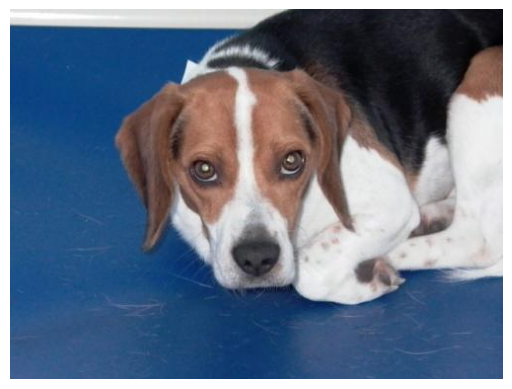

In [4]:
# Visualize a random image
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import random

all_images = list(directory_path.glob('*/*.jpg'))

random_image = random.choice(all_images)

img=plt.imread(random_image)
plt.imshow(img)
plt.axis(False)

In [5]:
# Create a function capable of visualising a couple of images randomly
import random
import PIL
from PIL import Image
import matplotlib.pyplot

def plot_images(directory_path, image_size:tuple=(224, 224), nb_img: int = 9):
    """
    Randomly lots multiple images so as to visualize the dataset we're
    working with

    Args :
        image_size = size of image to resize
        nb_img = number of images to plot
    """
    # Creates a list with all the images of cats and dogs combined
    all_images = list(directory_path.glob('*/*.jpg'))

    if nb_img > 9:
        print('ERROR : number of images to plot exceeded, please enter a number smaller or equal to 9')

    else :
        plt.figure(figsize=(10, 10))
        for i in range(nb_img):
            # Create list of unique image directories
            random_img = random.sample(all_images, nb_img)

            # Resize images so that they're all the same size
            img = Image.open(random_img[i])
            image_resized = img.resize(image_size)

            # Find the label of the corresponding image
            label = random_img[i].parent.name

            # Plot the images
            plt.subplot(3, 3, 1+i)
            plt.imshow(image_resized)
            plt.title(label)
            plt.axis(False)



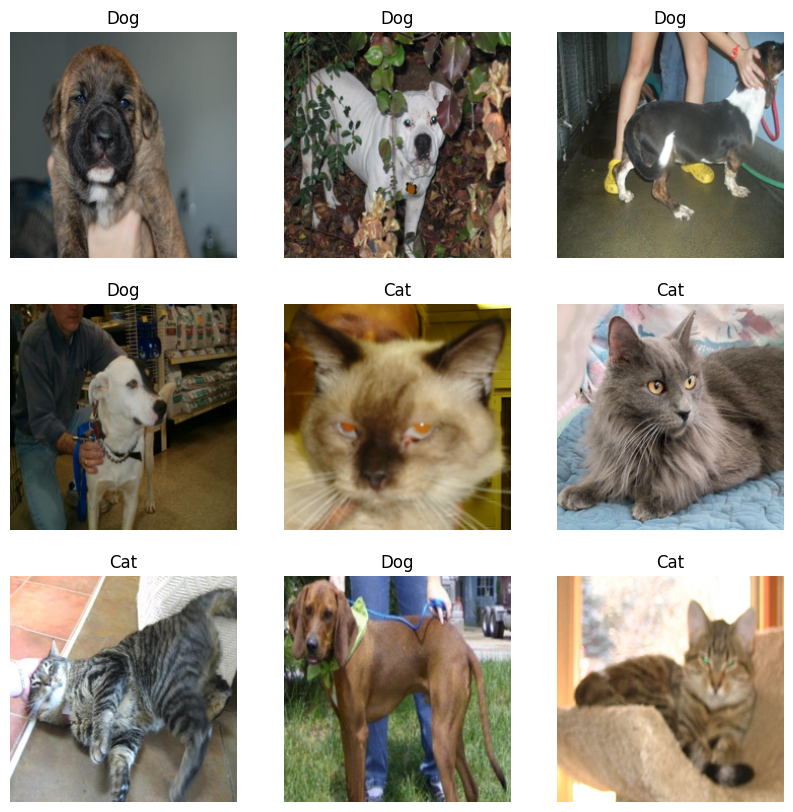

In [6]:
# Plot images
plot_images(directory_path)

## 2. Preparing our data

Now that we've visualised the data with which we'll be working on, it's time to set up the data !

In [7]:
from PIL import Image, UnidentifiedImageError, ImageFile
import os

# Prevent PIL from silently loading truncated images (optional)
ImageFile.LOAD_TRUNCATED_IMAGES = False

# Path to your dataset
dataset_dir = directory_path

# Counters
total_images = 0
skipped_images = 0

# Loop through each class folder
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Process each image in place
    for img_name in os.listdir(class_path):
        total_images += 1
        img_path = os.path.join(class_path, img_name)

        try:
            # Check if image is valid
            with Image.open(img_path) as img:
                img.verify()  # raises exception if corrupted

            # Re-open for manipulation
            with Image.open(img_path) as img:
                # Force 3 channels (RGB)
                img = img.convert('RGB')

                # Resize to 224x224 (optional)
                img = img.resize((224, 224))

                # Overwrite original file
                img.save(img_path)

        except (UnidentifiedImageError, OSError, ValueError) as e:
            skipped_images += 1
            print(f"Skipping corrupted/invalid image: {img_path} -> {e}")
            # Optionally delete the corrupted image
            # os.remove(img_path)

print(f"Total images processed: {total_images}")
print(f"Total images skipped: {skipped_images}")


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total images processed: 24998
Total images skipped: 0


In [8]:
# Import the necessary libraries
import tensorflow as tf

In [9]:
# Creating training and testing datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(directory_path,
                                                       batch_size = BATCH_SIZE,
                                                       image_size = IMG_SIZE,
                                                       shuffle = True,
                                                       validation_split = 0.25,
                                                       subset = 'training',
                                                       seed = 42 # Ensures reproductibility so that we can split the dataset into 75/25%
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(directory_path,
                                                      batch_size = BATCH_SIZE,
                                                      image_size = IMG_SIZE,
                                                      validation_split = 0.25,
                                                      subset = 'validation',
                                                      seed = 42 # Ensures reproductibility so that we can split the dataset into 75/25%
                                                     )



Found 24998 files belonging to 2 classes.
Using 18749 files for training.
Found 24998 files belonging to 2 classes.
Using 6249 files for validation.


In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
'''
# Optimize the pipeline
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = train_ds.unbatch()
val_ds  = val_ds.unbatch()

'''

'\n# Optimize the pipeline\ntrain_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)\nval_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)\n\ntrain_ds = train_ds.unbatch()\nval_ds  = val_ds.unbatch()\n\n'

Our images are now seperated into train and datasets, however to make our images more "realistic" we're going to proceed with data augmentation.

In [12]:
# Data augmentation
data_augment = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(20/360), # Rotate the image slightly between 0 and 20 degress
    tf.keras.layers.RandomShear(0.2), # shear the image
    tf.keras.layers.RandomZoom(0.2), # Zoom into the image
    tf.keras.layers.RandomTranslation(0.2, 0), # Shift the image witdh ways
    tf.keras.layers.RandomTranslation(0, 0.2), # Shift the image height ways
    tf.keras.layers.RandomFlip('horizontal')
])

Let's create our base model and try to beat it !

In [13]:
# Set the seed
tf.random.set_seed(42)

# 1. Create the model
base_model = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224,3), batch_size=BATCH_SIZE),
    #data_augment,
    tf.keras.layers.Conv2D(filters=32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# 2. Compile the model
base_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ['accuracy'])

In [14]:
# Fit the model
history_base_model = base_model.fit(train_ds,
                                    validation_data = val_ds,
                                    epochs = 5)


Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 43s 61ms/step - accuracy: 0.5947 - loss: 0.6756 - val_accuracy: 0.7492 - val_loss: 0.5154
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.7539 - loss: 0.5051 - val_accuracy: 0.7048 - val_loss: 0.6024
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.8000 - loss: 0.4323 - val_accuracy: 0.7782 - val_loss: 0.4867
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.8403 - loss: 0.3607 - val_accuracy: 0.7964 - val_loss: 0.4694
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.8738 - loss: 0.2910 - val_accuracy: 0.7964 - val_loss: 0.5546


Great let's visualise the training and test curves

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Plot the validation and training data seperately

def plot_tt_curves(history):
    """
    Returns seperate loss curves for training and validation metrics.
    """

    loss=history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

      # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

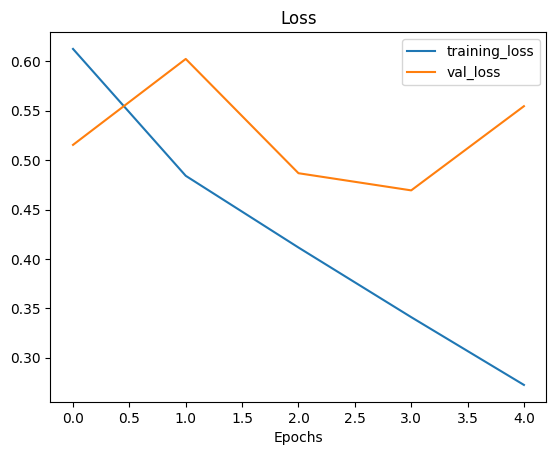

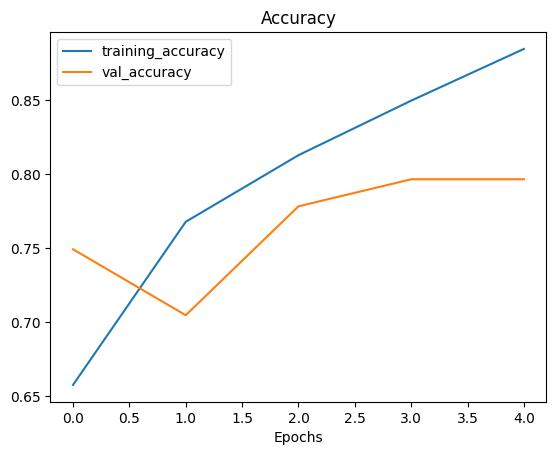

In [17]:
plot_tt_curves(history_base_model)

Our objective is to have the curves be as close as possible whilst maintaining the best accuracy/loss scores
Let us try and build a model that'll be able to surpass this one with the following changes :
* Add another Dense layer with 256 hidden units
* Add another Conv2D layer

In [18]:
# Set the seed
tf.random.set_seed(42)

# 1. Create the modem
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224,3), batch_size=BATCH_SIZE),
    #data_augment,
    tf.keras.layers.Conv2D(filters=32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(256, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# 2. Compile the model
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                   optimizer = tf.keras.optimizers.Adam(),
                   metrics = ['accuracy'])

In [19]:
# Fit the model
history_model_1 = model_1.fit(train_ds,
                                    validation_data = val_ds,
                                    epochs = 5)


Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - accuracy: 0.5693 - loss: 0.6781 - val_accuracy: 0.6985 - val_loss: 0.5674
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.7520 - loss: 0.5023 - val_accuracy: 0.7867 - val_loss: 0.4589
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.8110 - loss: 0.4081 - val_accuracy: 0.8116 - val_loss: 0.4107
Epoch 4/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.8609 - loss: 0.3195 - val_accuracy: 0.8395 - val_loss: 0.3908
Epoch 5/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.9034 - loss: 0.2321 - val_accuracy: 0.8478 - val_loss: 0.4225


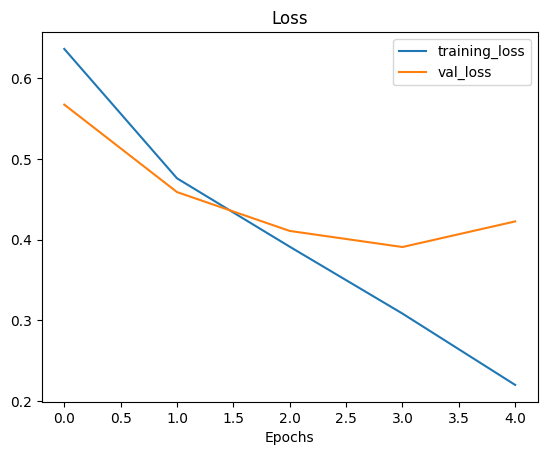

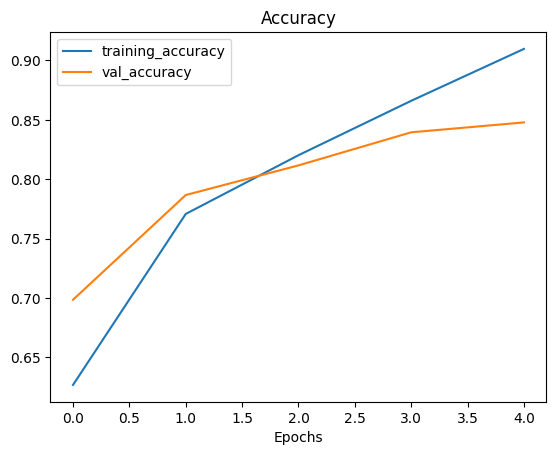

In [20]:
plot_tt_curves(history_model_1)

Let's try and boost our model's by using transfer learning. We will be using VGG16.

In [21]:
# Set the seed
tf.random.set_seed(42)

# Create the model
vgg = tf.keras.applications.VGG16(include_top = False)
vgg.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
#x = data_augment(inputs)
x = vgg(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

vgg_model = tf.keras.Model(inputs, outputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
# Compile the model
vgg_model.compile(loss=tf.keras.losses.binary_crossentropy,
                         optimizer = tf.keras.optimizers.Adam(),
                         metrics = ['accuracy'])

# Fit the model
history_vgg = vgg_model.fit(train_ds,
                     validation_data = val_ds,
                     epochs = 10)

Epoch 1/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 157s 245ms/step - accuracy: 0.7571 - loss: 0.5719 - val_accuracy: 0.8638 - val_loss: 0.4018
Epoch 2/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.8680 - loss: 0.3807 - val_accuracy: 0.8825 - val_loss: 0.3264
Epoch 3/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.8859 - loss: 0.3204 - val_accuracy: 0.8933 - val_loss: 0.2906
Epoch 4/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 216ms/step - accuracy: 0.8935 - loss: 0.2893 - val_accuracy: 0.8958 - val_loss: 0.2703
Epoch 5/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.9021 - loss: 0.2670 - val_accuracy: 0.9017 - val_loss: 0.2539
Epoch 6/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.9036 - loss: 0.2534 - val_accuracy: 0.9049 - val_loss: 0.2421
Epoch 7/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.9085 - loss: 0.2427 - val_accuracy: 0.9086 - val_loss: 0.2334
Epoch 8/10
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 217ms/step - accuracy: 0.9116 -

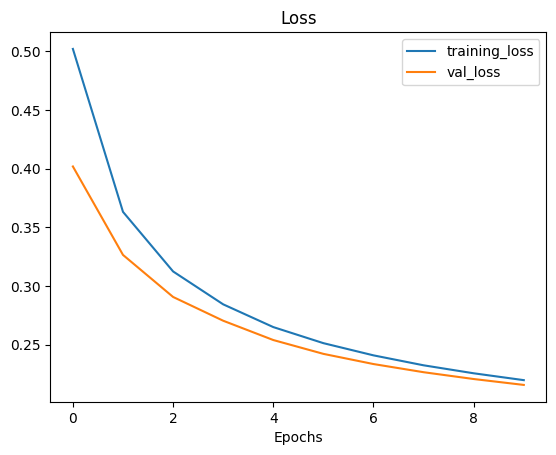

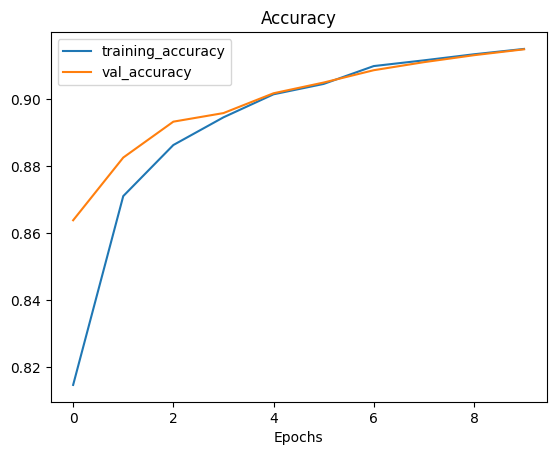

In [23]:
plot_tt_curves(history_vgg)

Let us try and predict a couple of images !

In [24]:
from tensorflow.keras.preprocessing import image

def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis("off")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    prediction = vgg_model.predict(img)[0][0]
    print(f"Prediction probability: {prediction:.4f}")
    print("Dog" if prediction >= 0.5 else "Cat")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction probability: 0.4417
Cat


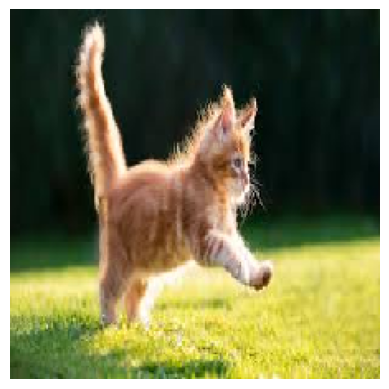

In [25]:
predict_image('Cat 1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction probability: 0.8736
Dog


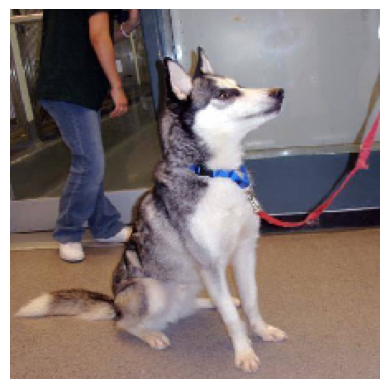

In [26]:
predict_image('dog.4001.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Prediction probability: 0.1960
Cat


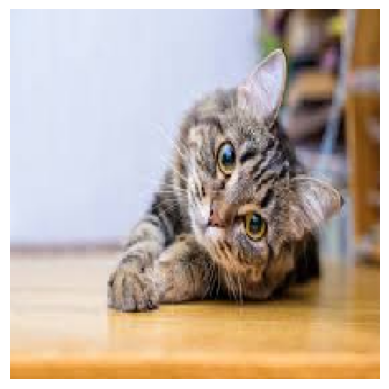

In [27]:
predict_image('Cat 2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Prediction probability: 0.0348
Cat


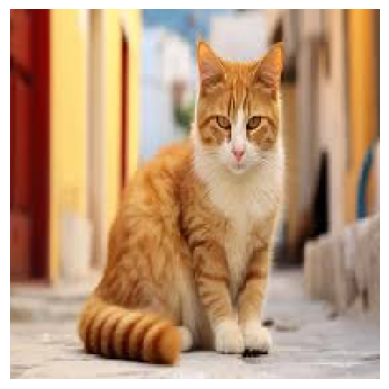

In [28]:
predict_image('Cat 3.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Prediction probability: 0.9913
Dog


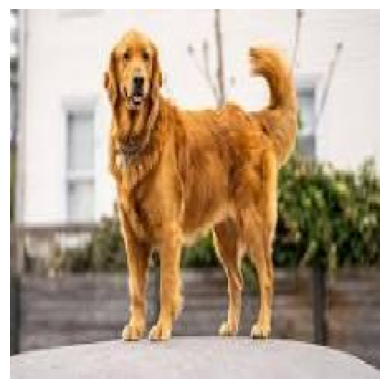

In [29]:
predict_image('Dog_2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction probability: 0.9996
Dog


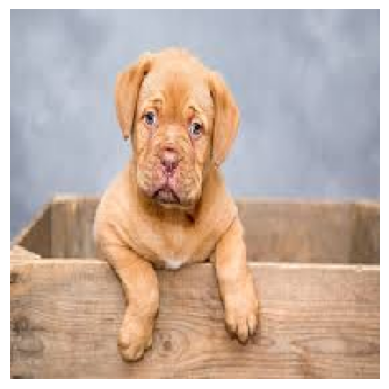

In [30]:
predict_image('Dog_3.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction probability: 0.3789
Cat


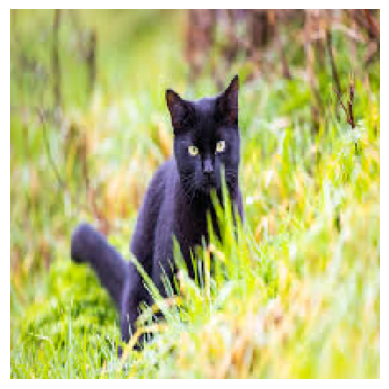

In [31]:
predict_image('Cat 4.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction probability: 0.0006
Cat


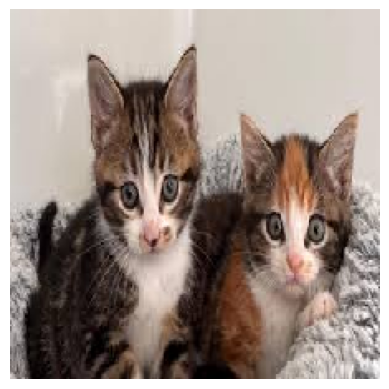

In [32]:
predict_image('Cat 5.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction probability: 0.1717
Cat


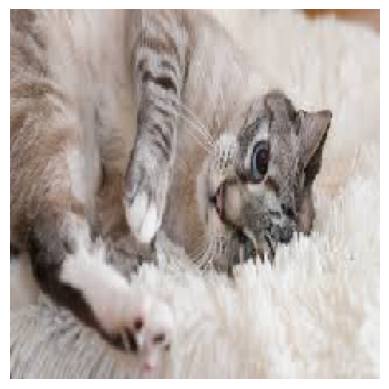

In [33]:
predict_image('Cat 6.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction probability: 0.0332
Cat


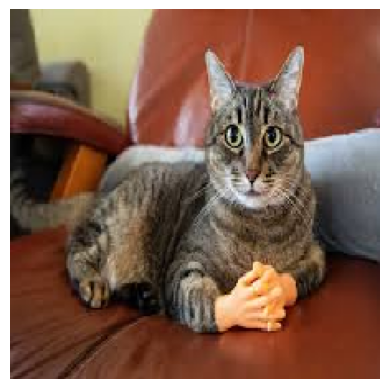

In [34]:
predict_image('Cat 7.jpg')

In [35]:
import zipfile  # make sure you import the module

dir_name = '/content/DL cat dog.zip'

# Use a different variable name
with zipfile.ZipFile(dir_name, 'r') as zip_ref:
    zip_ref.extractall()  # extracts to current directory


In [36]:
New_dir_path = Path("training_set/training_set")
test_ds = tf.keras.utils.image_dataset_from_directory(New_dir_path,
                                                      image_size=IMG_SIZE,
                                                      batch_size=BATCH_SIZE)


test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

Found 8005 files belonging to 2 classes.


In [37]:
# Extract both predictions and labels together
y_true = []
y_pred_prob = []

for x, y in test_ds:
    y_true.append(y.numpy())
    y_pred_prob.append(vgg_model.predict(x, verbose=0))

y_true = np.concatenate(y_true, axis=0).flatten()
y_pred_prob = np.concatenate(y_pred_prob, axis=0).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

In [38]:
# Creating a metrics function
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def model_results(y_true, y_pred):
    """
    Function to show to different metrics.
    """

    # Accuracy score :
    acc = accuracy_score(y_true, y_pred)

    #precision, recall, fscore
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    dic={"accuracy": acc, "precision": precision, "recall": recall, "f1-score": f1_score}

    return dic

In [39]:
model_results(y_true, y_pred)

{'accuracy': 0.9196752029981262,
 'precision': 0.9197288219331959,
 'recall': 0.9196752029981262,
 'f1-score': 0.9196729466281451}

Confusion Matrix:
 Axes(0.125,0.11;0.62x0.77)
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      4000
           1       0.92      0.91      0.92      4005

    accuracy                           0.92      8005
   macro avg       0.92      0.92      0.92      8005
weighted avg       0.92      0.92      0.92      8005



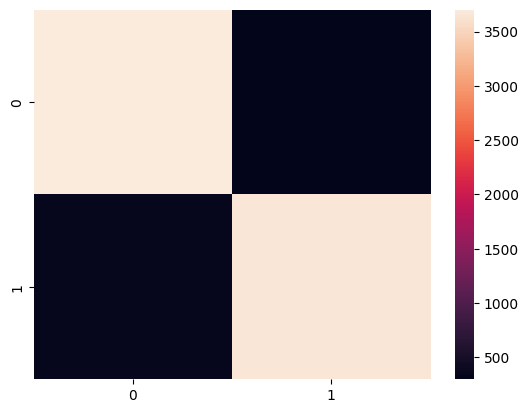

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("Confusion Matrix:\n", sns.heatmap(confusion_matrix(y_true, y_pred)))
print("Classification Report:\n", classification_report(y_true, y_pred))